## Exploratory Data Analysis
### On Animals data downloaded from Data Service API
#### Possible animals considered: Kangaroo, Elephant, Chicken, and Dog


In [39]:
# Import packages
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import joblib


from src.api_call import fetch_animals, fetch_schema
from src.minio_connection import minio_save_model

In [24]:
# Load data
df = pd.DataFrame(fetch_animals(1000)[0])
df

,walks_on_n_legs,height,weight,has_wings,has_tail
0,2,1.896620,52.244593,False,True
1,2,1.870680,84.608978,False,True
2,4,0.151612,7.855076,False,True
3,2,1.824498,75.800981,False,True
4,4,0.279900,46.757356,False,True
...,...,...,...,...,...
995,4,0.643381,32.938410,False,True
996,4,0.251529,44.388866,False,True
997,2,0.352178,3.259972,True,True
998,4,3.230949,5434.916251,False,True


In [25]:
# Group and aggregate: mean height, mean weight, and count (frequency)
agg_table = (
    df.groupby(['has_tail', 'has_wings', 'walks_on_n_legs'])
      .agg(
          avg_height=('height', 'mean'),
          avg_weight=('weight', 'mean'),
          frequency=('height', 'count')
      )
      .reset_index()
)

print(agg_table)

df.describe()

    has_tail  has_wings  walks_on_n_legs  avg_height   avg_weight  frequency
0      False      False                1    5.217312   314.538443          2
1      False      False                2    6.790621   948.823529          1
2      False      False                4    9.103566   688.203915          1
3      False      False                5    4.619763    54.204085          1
4      False       True                1    9.263670   848.695734          1
5      False       True                2    6.377656   697.890595          2
6      False       True                3    1.379124   598.917368          2
7      False       True                4    1.728072   214.716106          1
8      False       True                5    4.346714   642.179210          4
9       True      False                1    2.226530   377.204032          3
10      True      False                2    1.849558    72.477546        249
11      True      False                3    5.434693   998.728175          1

,walks_on_n_legs,height,weight
count,1000.000000,1000.000000,1000.000000
mean,2.995000,1.492775,1146.052381
std,1.024707,1.337228,2046.772823
min,1.000000,0.136315,0.075579
25%,2.000000,0.384612,6.125841
50%,2.500000,1.614983,57.705723
75%,4.000000,2.514369,731.899037
max,5.000000,9.839360,6897.044478


In [26]:
# Filter out impossible data combinations:
# 1. Animals can only walk with 2 or 4 legs
df = df[df['walks_on_n_legs'].isin([2, 4])]

# 2. Animals with wings can only walk in 2 legs
df = df[~(df['walks_on_n_legs'] == 4) | (df['has_wings'] == False)]

# 3. All animals in the dataset have a tail
df = df[df['has_tail'] == True]

In [27]:
# Group and aggregate: mean height, mean weight, and count (frequency)
agg_table = (
    df.groupby(['has_tail', 'has_wings', 'walks_on_n_legs'])
      .agg(
          avg_height=('height', 'mean'),
          avg_weight=('weight', 'mean'),
          frequency=('height', 'count')
      )
      .reset_index()
)

print(agg_table)

   has_tail  has_wings  walks_on_n_legs  avg_height   avg_weight  frequency
0      True      False                2    1.849558    72.477546        249
1      True      False                4    1.681196  2301.094150        482
2      True       True                2    0.360987     6.250308        239


In [28]:
# Based in this analysis it can be inferred the class for all animals which walk on 2 legs:

df['animal_type'] = None

# Set to 'chicken' if walks on 2 legs and has wings
df.loc[(df['walks_on_n_legs'] == 2) & (df['has_wings'] == True), 'animal_type'] = 'chicken'

# Set to 'kangaroo' if walks on 2 legs and no wings
df.loc[(df['walks_on_n_legs'] == 2) & (df['has_wings'] == False), 'animal_type'] = 'kangaroo'


In [29]:
df_4legs = df[(df['walks_on_n_legs'] == 4)].drop(columns=['animal_type'])

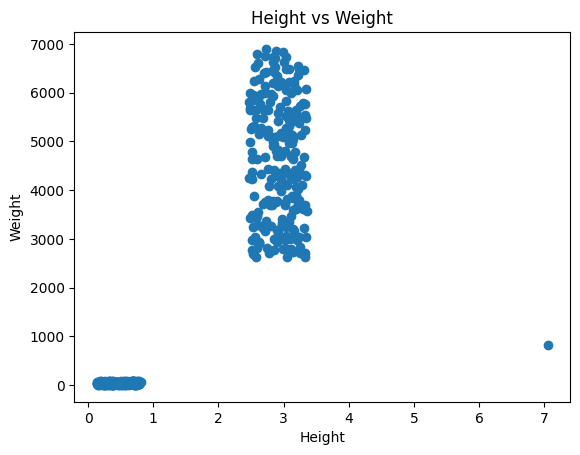

In [30]:
plt.scatter(df_4legs['height'],df_4legs['weight'])  
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs Weight')
plt.show()

In [31]:
# TODO: Create clusteing model to classify Dogs vs Elephants

# Set to 'elephant' if heavy
df.loc[(df['weight'] >= 1500) & (df['animal_type'].isnull()), 'animal_type'] = 'elephant'

# Set to 'dog' if light
df.loc[(df['weight'] < 1500) & (df['animal_type'].isnull()), 'animal_type'] = 'dog'

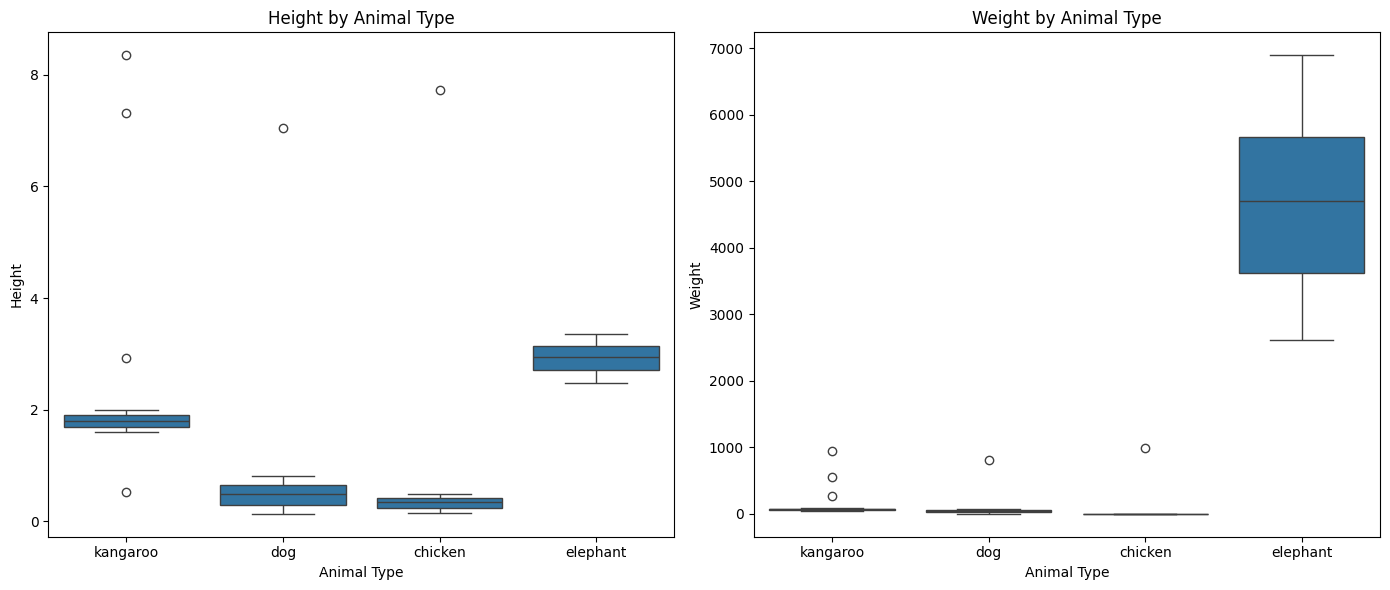

In [32]:
# Plotting weight and height for each animal type
plt.figure(figsize=(14, 6))

# Boxplot for Height
plt.subplot(1, 2, 1)
sns.boxplot(x='animal_type', y='height', data=df)
plt.title('Height by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Height')

# Boxplot for Weight
plt.subplot(1, 2, 2)
sns.boxplot(x='animal_type', y='weight', data=df)
plt.title('Weight by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()


In [33]:
def remove_outliers_iqr(df):
    
    df_filtered = pd.DataFrame()
    cols_to_filter=['height', 'weight']

    for name, group in df.groupby('animal_type'):
        group_filtered = group.copy()
        for col in cols_to_filter:
            Q1 = group[col].quantile(0.25)
            Q3 = group[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            group_filtered = group_filtered[(group_filtered[col] >= lower) & (group_filtered[col] <= upper)]
        df_filtered = pd.concat([df_filtered, group_filtered], ignore_index=True)
    
    return df_filtered

df_cleaned = remove_outliers_iqr(df, )

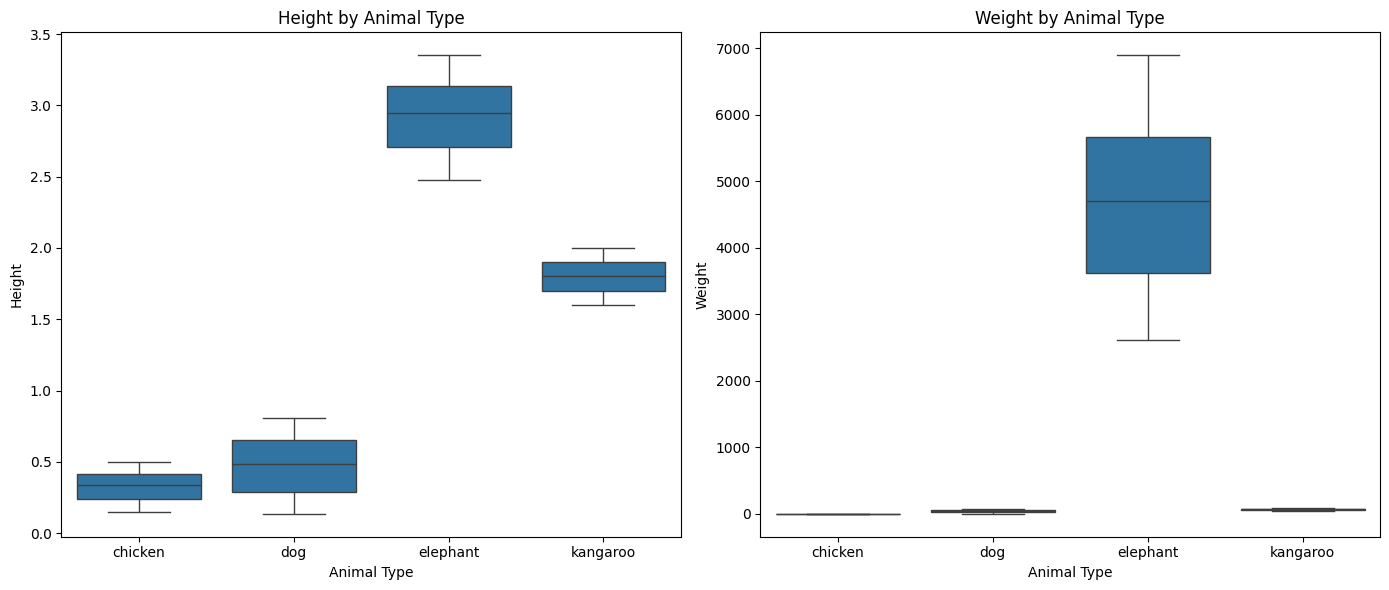

In [34]:
# Plotting weight and height for each animal type
plt.figure(figsize=(14, 6))

# Boxplot for Height
plt.subplot(1, 2, 1)
sns.boxplot(x='animal_type', y='height', data=df_cleaned)
plt.title('Height by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Height')

# Boxplot for Weight
plt.subplot(1, 2, 2)
sns.boxplot(x='animal_type', y='weight', data=df_cleaned)
plt.title('Weight by Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()

In [35]:
# Split data for training and testing
X = df_cleaned[['height', 'weight', 'walks_on_n_legs', 'has_wings', 'has_tail']]
y = df_cleaned['animal_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

# Print several performance metrics
acc = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average='macro')
recall = recall_score(y_test, y_predict, average='macro')
f1 = f1_score(y_test, y_predict, average='macro')

metrics = {
    "accuracy": round(acc, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1_score": round(f1, 4)
}

print(metrics)


{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


In [ ]:
# Save model to minio
minio_save_model(model=model, metrics=metrics)

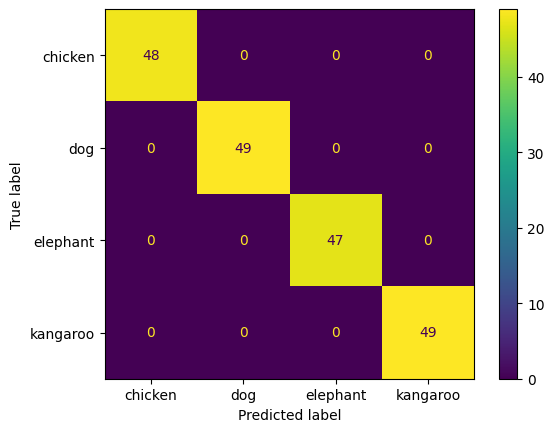

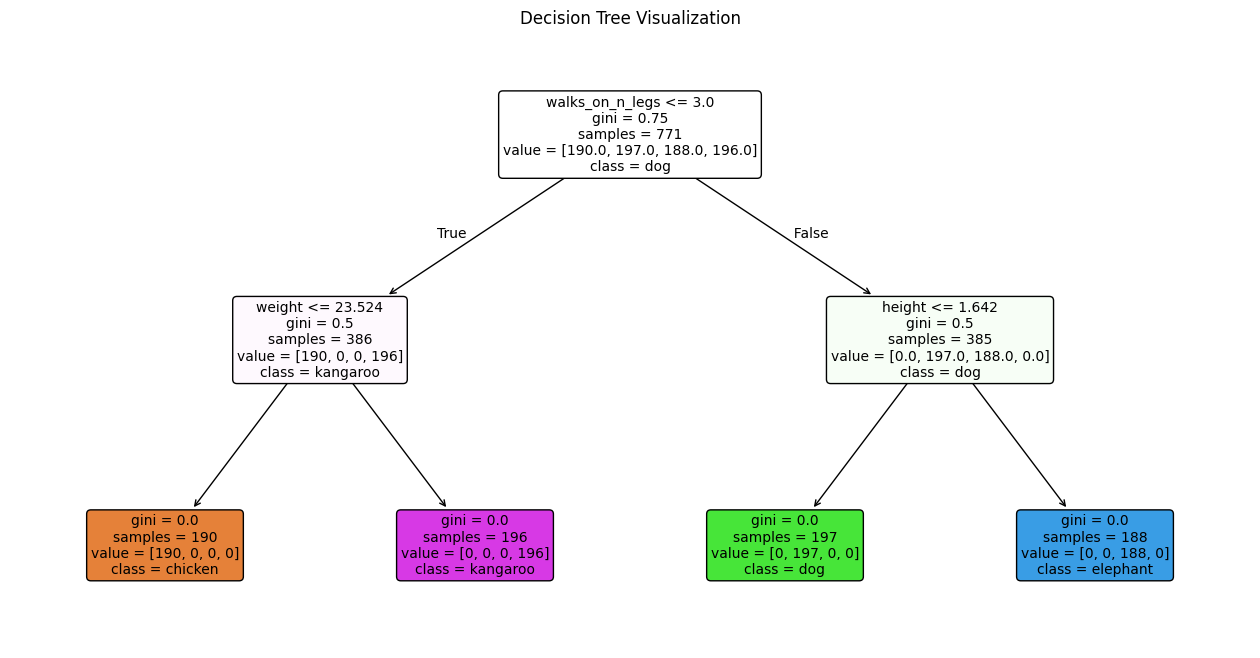

In [37]:


# Print confuxion matrix
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Plot the tree
plt.figure(figsize=(16, 8))
plot_tree(model, 
          feature_names=X.columns, 
          class_names=model.classes_, 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()